# DiT Recon Visualization

Load reconstructed TSVs from `checkpoints/dit/samples_epochXXX` and visualize. Adjust `epoch`/`num_show` if needed.

Found 500 TSVs under outputs\dit_samples\CrossDiT-L\Pair_68_sim_hic_freq
G values per sample:
sample_0307: G=1.1999
sample_0094: G=1.1999
sample_0213: G=1.5997
sample_0450: G=1.1999
sample_0093: G=1.6002
Saved visualization to outputs\dit_samples\CrossDiT-L\Pair_68_sim_hic_freq\recon_vis.png


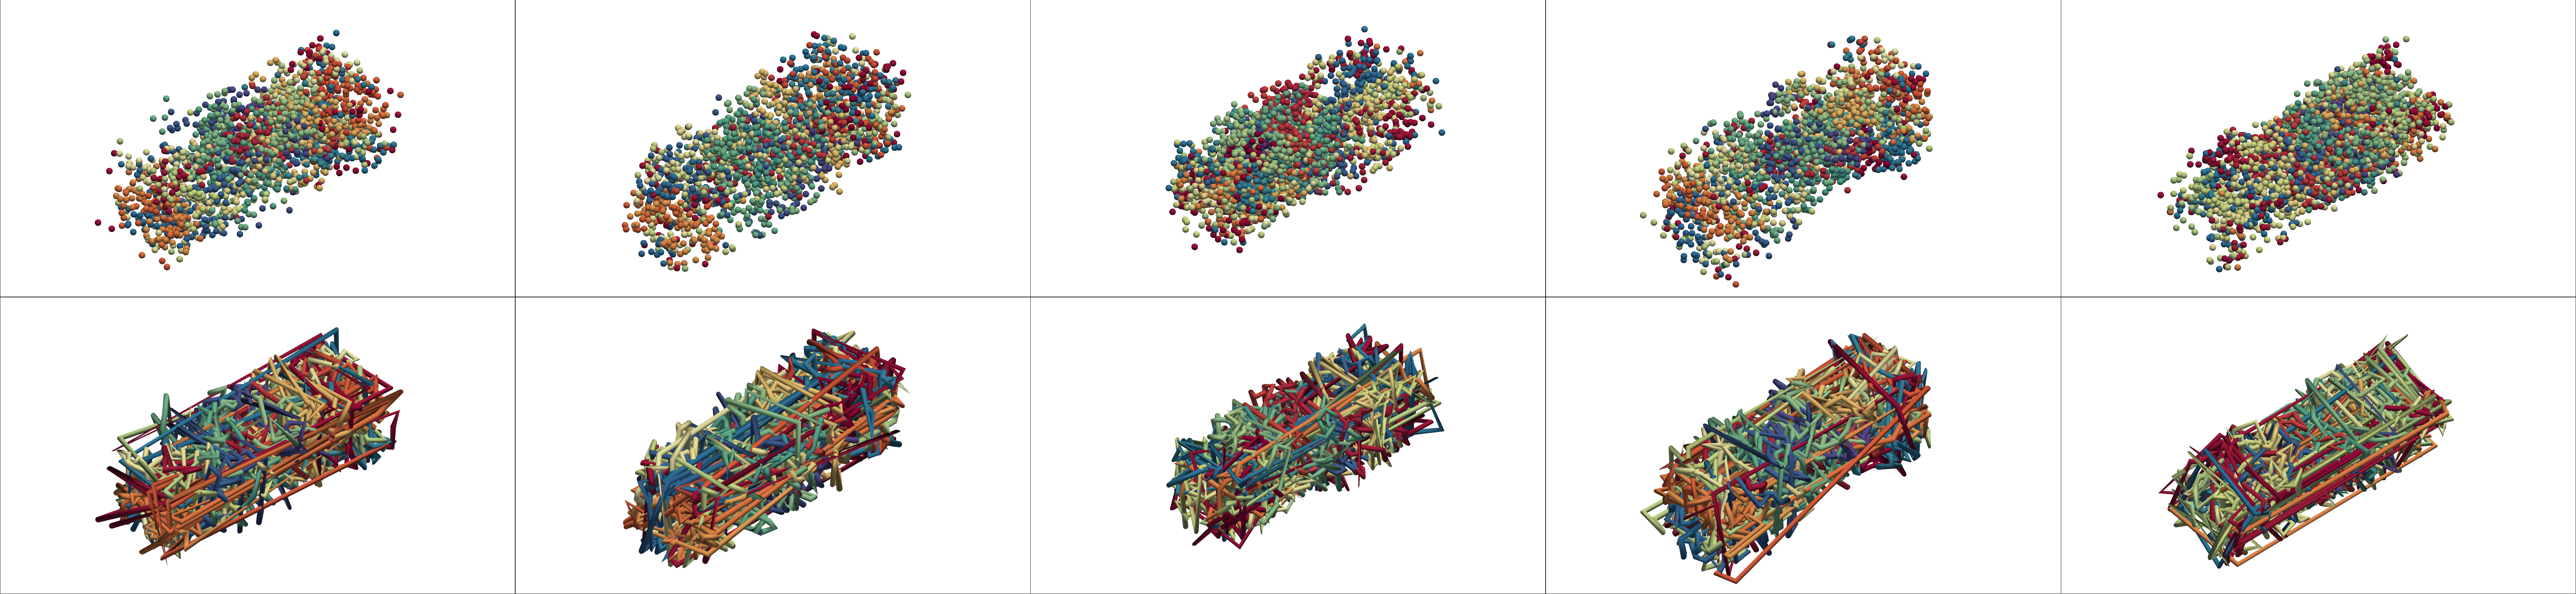

In [5]:
import os, glob, torch, numpy as np
from IPython.display import Image, display
import importlib
import scripts.visualization_vae as viz
viz = importlib.reload(viz)
from scripts.visualization_vae import collect_chain_points, add_polyline
import numpy.linalg as LA
import pyvista as pv
from pathlib import Path
import pandas as pd
import random

# Settings
samples_dir = Path("outputs/dit_samples/CrossDiT-L/Pair_68_sim_hic_freq")
num_show = 5                      # number of samples to visualize
COLORMAP = 'Spectral'


def pca_align(points: np.ndarray):
    center = points.mean(axis=0, keepdims=True)
    pts0 = points - center
    U, S, Vt = LA.svd(pts0, full_matrices=False)
    R = Vt.T
    if LA.det(R) < 0:
        R[:, -1] *= -1
    aligned = pts0 @ R
    return aligned, center, R


def compute_G(struct_tensor: torch.Tensor):
    chain_orig = ((struct_tensor[...,3]>0.5).sum() + (struct_tensor[...,11]>0.5).sum()).item()
    chain_copy = ((struct_tensor[...,7]>0.5).sum() + (struct_tensor[...,15]>0.5).sum()).item()
    if chain_orig == 0:
        return float('inf')
    return (chain_copy / chain_orig) + 1.0


def load_struct_tensor(struct_path: str, device: torch.device):
    df = pd.read_csv(struct_path, sep="\t")
    df = df.drop(columns=[c for c in df.columns if c.startswith("bead_index")], errors="ignore")
    expected = ["hic_index", "x1", "y1", "z1", "mask1", "x2", "y2", "z2", "mask2"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"{struct_path}: missing columns {missing}")

    tokens = []
    for _, g in df.groupby("hic_index", sort=False):
        if len(g) == 0:
            continue
        if len(g) == 1:
            r1 = g.iloc[0]
            r2 = None
        else:
            if len(g) > 2:
                g = g.iloc[:2]
            r1 = g.iloc[0]
            r2 = g.iloc[1]

        def row_feats(r):
            if r is None:
                return [0.0] * 8
            return [
                float(r["x1"]), float(r["y1"]), float(r["z1"]), float(r["mask1"]),
                float(r["x2"]), float(r["y2"]), float(r["z2"]), float(r["mask2"]),
            ]

        tokens.append(row_feats(r1) + row_feats(r2))

    if not tokens:
        raise ValueError(f"{struct_path}: no valid rows after grouping by hic_index")

    struct_tensor = torch.tensor(tokens, dtype=torch.float32).unsqueeze(0).to(device)  # (1,W,16)
    return struct_tensor, df


# Only sample a few TSVs for visualization
all_tsv = list(samples_dir.glob("sample_*.tsv"))
print(f'Found {len(all_tsv)} TSVs under {samples_dir}')
if len(all_tsv) == 0:
    raise SystemExit('No TSV files found')

num_show = min(num_show, len(all_tsv))
sel_files = random.sample(all_tsv, k=num_show)

orig_list, names, G_values = [], [], []
for p in sel_files:
    struct_tensor, _ = load_struct_tensor(p, torch.device('cpu'))
    orig_list.append(struct_tensor.cpu())
    names.append(os.path.splitext(os.path.basename(p))[0])
    G_values.append(compute_G(struct_tensor.squeeze(0)))

print('G values per sample:')
for n, g in zip(names, G_values):
    print(f'{n}: G={g:.4f}')

orig_cat = torch.cat(orig_list, dim=0)
max_idx = max(0, orig_cat.shape[1] - 1)
clim = (0.0, float(max_idx))
colors = ['orig', 'copy']

# select samples (already sampled)
total = orig_cat.size(0)
num_show = min(num_show, total)
sel_idx = torch.arange(num_show)
orig_cat = orig_cat[sel_idx]
names_sel = [names[i] for i in sel_idx]

plotter = pv.Plotter(shape=(2, num_show), window_size=(num_show * 520, 600), off_screen=True)


def set_cam(pl, pts, shrink=0.9):
    center = pts.mean(axis=0)
    max_range = np.ptp(pts, axis=0).max()
    max_range = max(max_range, 1e-3)
    offset = max_range * 2.0
    pl.camera.focal_point = center
    pl.camera.position = center + np.array([offset, offset, offset])
    pl.camera.up = (0,0,1)
    pl.camera.parallel_projection = True
    pl.camera.parallel_scale = (max_range * 0.5) * shrink

for i in range(num_show):
    struct = orig_cat[i]
    chains = []  # list of (pts, idxs)
    for tag in colors:
        pts, idxs = collect_chain_points(struct, tag)
        if len(pts) == 0:
            continue
        chains.append((np.asarray(pts), np.asarray(idxs, dtype=np.float32)))
    if not chains:
        continue

    concat = np.concatenate([c[0] for c in chains], axis=0)
    aligned_all, center, R = pca_align(concat)
    transform = lambda pts: (pts - center) @ R

    # scatter row
    plotter.subplot(0, i)
    for pts, idxs in chains:
        plotter.add_points(
            transform(pts),
            scalars=idxs,
            cmap=COLORMAP,
            clim=clim,
            point_size=20,
            render_points_as_spheres=True,
            show_scalar_bar=False,
        )
    set_cam(plotter, aligned_all)
    plotter.remove_bounds_axes()

    # line row
    plotter.subplot(1, i)
    for pts, idxs in chains:
        add_polyline(plotter, transform(pts), idxs, width=0.3, clim=clim, cmap=COLORMAP)
    set_cam(plotter, aligned_all)
    plotter.remove_bounds_axes()

out_path = str(samples_dir / 'recon_vis.png')
os.makedirs(samples_dir, exist_ok=True)
plotter.screenshot(out_path, scale=3.0)
plotter.close()
print(f'Saved visualization to {out_path}')
display(Image(filename=out_path))
